In [42]:
from loader.taps import TactileDataset

dataset = TactileDataset('/home/hussain/me/projects/events_nn/data/morethan3500ev_lessthan_9deg/train', features='pol')

#%%
d = dataset[100]
d



{'bag': '/media/kucarst3-dlws/drive1/tactile-data/data2', 'train_prop': 0.75, 'delta_t': 150000000.0, 'margin': -50000000.0, 'min_n_events': 3500, 'n_init_events': -1, 'downsample_factor': 2, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 20, 'possible_angles': [0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295], 'theta': 'full', 'augmentations': [], 'filters': ['RemovePhiBiggerThan(max_phi=0.15707963267948966)', '<imports.EventArrayFilter.RemoveNEventsLessThan object at 0x7fb968c2a5c0>'], 'n': 2292, 'node_features': 'pol'}


Data(x=[8061, 1], edge_index=[2, 119776], y=[1, 2], pos=[8061, 3], edge_attr=[119776, 3])

In [43]:
import torch
from torch_geometric.utils import remove_isolated_nodes
from torch_geometric.transforms import LargestConnectedComponents

lcc = LargestConnectedComponents(1)

data = d.cuda()
max_x = 170
patch_size = 10

data = lcc(data)

floor_pos = torch.div(data.pos, patch_size, rounding_mode='floor')
node_patch_map = floor_pos[:, 0] * (max_x // patch_size) + floor_pos[:, 1] 
edges_in_same_patch = node_patch_map[data.edge_index[0]] == node_patch_map[data.edge_index[1]]
valid_edges = data.edge_index[:, edges_in_same_patch]
valid_edge_attr = data.edge_attr[edges_in_same_patch]
edge_patch_map = node_patch_map[valid_edges[0]]


In [44]:
from torch_geometric.data import Data

data1 = Data(x=data.x, edge_index=valid_edges, pos=data.pos, y=data.y, edge_attr=valid_edge_attr).cuda()
data1

Data(x=[8007, 1], edge_index=[2, 33146], edge_attr=[33146, 3], y=[1, 2], pos=[8007, 3])

In [45]:
from torch_geometric.nn import SplineConv

conv = SplineConv(1, 8, dim=3, kernel_size=3).cuda()
out = conv(data1.x.cuda(), data1.edge_index.cuda(), data1.edge_attr.cuda())
out.shape

torch.Size([8007, 8])

In [50]:
out

tensor([[ 0.1867, -0.6308, -0.3876,  ...,  0.7682,  0.6510,  0.6300],
        [-0.2129,  0.6685,  0.3189,  ..., -0.7267, -0.7104, -0.5730],
        [-0.1781,  0.6431,  0.3543,  ..., -0.6893, -0.7263, -0.5997],
        ...,
        [-0.1836,  0.6426,  0.3872,  ..., -0.7709, -0.6522, -0.6283],
        [-0.2115,  0.6666,  0.3929,  ..., -0.7499, -0.6355, -0.6122],
        [-0.1867,  0.6308,  0.3876,  ..., -0.7682, -0.6510, -0.6300]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [51]:
data1

Data(x=[8007, 1], edge_index=[2, 33146], edge_attr=[33146, 3], y=[1, 2], pos=[8007, 3])

In [ ]:
import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import to_scipy_sparse_matrix

adj = to_scipy_sparse_matrix(data1.edge_index, num_nodes=data1.num_nodes)

num_components, component = sp.csgraph.connected_components(adj, connection='weak')
num_components


1389

In [ ]:
17*17

289

In [ ]:
edge_patch_map

tensor([242., 242., 146.,  ..., 167., 167., 167.])

In [ ]:
d.edge_index

tensor([[   4,    3,   22,  ..., 8028, 7908, 7826],
        [   3,    4,    7,  ..., 8059, 8060, 8060]])

In [ ]:
node_patch_map.unique()

tensor([  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  36.,  37.,  38.,  39.,  40.,
         41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  52.,  53.,  55.,  56.,
         57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  68.,  69.,
         70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
         82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
         94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
        106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
        118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
        130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
        142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
        154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
        166., 167., 168., 169., 170., 17

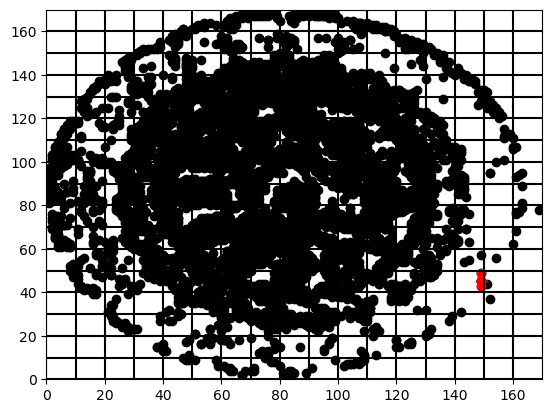

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.xlim(0, 170)
plt.ylim(0, 170)

for i in range(0, 170, 10):
    plt.axvline(i, c='k')
    plt.axhline(i, c='k')

# for j in range(17**2):
#     idx = node_patch_map == j
#     plt.scatter(data.pos[idx, 0], data.pos[idx, 1], c=list(mcolors.CSS4_COLORS.keys())[j])

plt.scatter(data.pos[:, 0], data.pos[:, 1], c='k')
idx = node_patch_map == 242
plt.scatter(data.pos[idx, 0], data.pos[idx, 1], c='r')

In [ ]:
torch.where(node_patch_map == 242)

(tensor([   0,    3,    4,   19,   73,  213, 5841, 6359, 7423]),)

In [ ]:
node_patch_map

tensor([242.,  45., 154.,  ...,  56., 167.,  24.])

In [ ]:
data.edge_index

tensor([[   4,    3,   22,  ..., 8028, 7908, 7826],
        [   3,    4,    7,  ..., 8059, 8060, 8060]])

In [ ]:
node_patch_map

tensor([242.,  45., 154.,  ...,  56., 167.,  24.])

In [ ]:
node_patch_map[data.edge_index[0]]

tensor([])

In [ ]:
import torch
pos = torch.ones((170, 170)).nonzero()
pos

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [169, 167],
        [169, 168],
        [169, 169]])

In [ ]:
170 // 10

17

In [ ]:
(pos // 10).to_dense()

/tmp/ipykernel_23838/2489096943.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (pos // 10).to_dense()


tensor([[ 0,  0],
        [ 0,  0],
        [ 0,  0],
        ...,
        [16, 16],
        [16, 16],
        [16, 16]])

In [ ]:
pos[170]

tensor([1, 0])

In [ ]:
(pos // 10)

SyntaxError: invalid syntax (1486662894.py, line 1)

In [ ]:
floor_pos = torch.div(pos, patch_size, rounding_mode='floor')
patch_map = floor_pos[:, 0] * (170 // patch_size) + floor_pos[:, 1] 
patch_map

tensor([  0,   0,   0,  ..., 288, 288, 288])

In [ ]:
17*17

289

In [ ]:
import torch

torch.div(d.pos[0], patch_size, rounding_mode='floor')

tensor([7., 8., 0.])